### Universidad Panamericana
## Natural Language Processing
# Final Project
#
### Efrén Flores Porras (0223214)
### Ramón Andrés Galindo Gerardo (0248040)

## Libraries

In [43]:
# -----------------------------------
# pandas
# -----------------------------------
import pandas as pd

# -----------------------------------
# numpy
# -----------------------------------
import numpy as np

# -----------------------------------
# plots
# -----------------------------------
import matplotlib.pyplot as plt

# -----------------------------------
# sklearn
# -----------------------------------
from sklearn.model_selection import train_test_split # to split datasets
from sklearn.feature_extraction.text import TfidfVectorizer # to vectorize text
# model training
from sklearn import svm # support vector machines
from sklearn.tree import DecisionTreeClassifier # decission trees
from sklearn.linear_model import LogisticRegression # logistic regression
from sklearn.ensemble import RandomForestClassifier # random forest classifier
# model performance
from sklearn.model_selection import GridSearchCV # to look for optimal training parameters
from sklearn.metrics import classification_report, accuracy_score # to measure the models

# -----------------------------------
# TensorFlow
# -----------------------------------
# For preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Modelling
from tensorflow.keras.models import Sequential # multi-layer nn
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Conv1D, AveragePooling1D, Flatten, LSTM, Dropout # layer types
# callbacks
from tensorflow.keras.callbacks import EarlyStopping

# -----------------------------------
# Hyperparameters tunning
# -----------------------------------
import keras_tuner as kt

# -----------------------------------
# Text processing
# -----------------------------------
import re
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import words
from difflib import get_close_matches


## Preprocessing

In [44]:
def encode_sentiment(rating, sentiment_type='positive'):
    match sentiment_type:
        case 'positive':
            return rating > 3
        case 'ambiguous':
            return rating == 3
        case 'negative':
            return rating < 3
        
def label_category(df):
    max_i = np.argmax(np.array([df['positive'], df['ambiguous'], df['negative']]))
    match max_i:
        case 0:
            return 'positive'
        case 1:
            return 'ambiguous'
        case 2:
            return 'negative'

# Preload the words corpus into a set for faster checking
words_set = set(words.words())

def checkSpelling(word):
    # Fix contractions in the word
    word = contractions.fix(word)
    
    # Clean the word
    clean_word = re.sub(r'[^\w]', '', word.lower())
    
    # Check if the word is in the dictionary
    if clean_word and clean_word not in words_set:
        # Get the best match
        suggestions = get_close_matches(clean_word, words_set, n=1, cutoff=0.8)
        return suggestions[0] if suggestions else clean_word
    else:
        return clean_word

# Preload stopwords and initialize lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def correct_text(text):
    # -----------------------------------
    # Contractions & Spelling
    # -----------------------------------
    words = text.split()
    corrected_words = [checkSpelling(word) for word in words]
    text = ' '.join(corrected_words)

    # -----------------------------------
    # Cleaning and Normalization
    # -----------------------------------
    # Removing special characters
    text = re.sub(r'[^\w\s]', '', text)
    
    # Removing Stopwords
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    
    # Lemmatization
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]
    
    return ' '.join(lemmatized_words)

    return text

def get_data(path, numrows=200):
    # -----------------------------------
    # preprocessing
    # -----------------------------------
    data = pd.read_csv(path, header=0) # loading the data into a pandas dataframe
    data.dropna(inplace=True) # encoding the data
    # consider only the first numrows rows
    data = data.iloc[0:numrows,:]
    # clearing the data
    data['Reviews'] = data['Reviews'].apply(correct_text) # correcting text
    # encoding sentiments
    data['positive'] = data['Rating'].apply(encode_sentiment, sentiment_type='positive')
    data['ambiguous'] = data['Rating'].apply(encode_sentiment, sentiment_type='ambiguous')
    data['negative'] = data['Rating'].apply(encode_sentiment, sentiment_type='negative')
    # putting necessary data into a new dataframe
    data.rename(columns = {'Reviews':'review'}, inplace = True)
    cleandata = data[['review', 'positive', 'ambiguous', 'negative']] # only necessary columns
    cleandata['label'] = data.apply(label_category, axis=1)
    cleandata = cleandata.iloc[0:numrows,:] # only first numrows rows
    return cleandata

In [45]:
def split_dataset(dataset, test_size=0.2):
    dataset_training, dataset_test = train_test_split(dataset, test_size=test_size, random_state=0)
    return dataset_training, dataset_test

In [46]:
def tokenize_text(
        text_training,
        text_testing,
        vocab_size=10000,
        max_length=100,
        padding_type='post',
        trunc_type='post',
        oov_tok="<OOV>"
        ):
    tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
    tokenizer.fit_on_texts(text_training)

    processedText_training = np.array(pad_sequences(tokenizer.texts_to_sequences(text_training), maxlen=max_length, padding=padding_type, truncating=trunc_type))
    processedText_testing = np.array(pad_sequences(tokenizer.texts_to_sequences(text_testing), maxlen=max_length, padding=padding_type, truncating=trunc_type))

    return processedText_training, processedText_testing

### ML

In [47]:
def tuneAndFit_mlModel(
    model,
    tuning_params,
    textvectors_training,
    labels_training,
    cv=5,
    verbose_level=1
    ):

    gridsearch = GridSearchCV(
        model,
        param_grid=tuning_params,
        cv=cv,
        verbose=verbose_level
    )
    gridsearch.fit(textvectors_training, labels_training)
    
    return gridsearch.best_estimator_


### Neural Networks

In [48]:
def modelBuilder_mlp(
    hp,
    vocab_size = 10000,
    opt = 'adam',
    loss_fun = 'binary_crossentropy',
    acc = ['accuracy']
    ):

    hp_embedding_dim = hp.Int('embedding_dim', min_value=8, max_value=40 , step=8)
    hp_max_length = hp.Int('input_length', min_value=80, max_value=120, step=10)
    hp_activationFunction_dense1 = hp.Choice('activation_dense', values=['relu', 'sigmoid', 'tanh'])
    hp_activationFunction_dense2 = hp.Choice('activation_dense', values=['relu', 'sigmoid', 'tanh'])

    model_mlp = Sequential([
        Embedding(vocab_size, hp_embedding_dim, input_length=hp_max_length),
        GlobalAveragePooling1D(),
        Dense(24, activation=hp_activationFunction_dense1),
        Dense(3, activation=hp_activationFunction_dense2)
        ])
    model_mlp.compile(
        optimizer = opt,
        loss = loss_fun,
        metrics = acc
        )
    
    return model_mlp

In [49]:
def modelBuilder_cnn(
    hp,
    vocab_size = 10000,
    opt = 'adam',
    loss_fun = 'binary_crossentropy',
    acc = ['accuracy']
    ):

    hp_embedding_dim = hp.Int('embedding_dim', min_value=8, max_value=40 , step=8)
    hp_max_length = hp.Int('input_length', min_value=80, max_value=120, step=10)
    hp_filters = hp.Int('filters', min_value=2, max_value=10, step=2)
    hp_units = hp.Int('units', min_value=2, max_value=16, step=2)
    hp_activation_conv = hp.Choice('activation_conv', values=['relu', 'sigmoid', 'tanh'])
    hp_activation_dense = hp.Choice('activation_dense', values=['relu', 'sigmoid', 'tanh'])

    model_cnn = Sequential([
        Embedding(vocab_size, hp_embedding_dim, input_length=hp_max_length),
        Conv1D(filters=hp_filters, kernel_size=3, activation=hp_activation_conv, name="Conv1D"),
        AveragePooling1D(pool_size=3),
        Flatten(),
        Dense(units=hp_units, activation=hp_activation_dense),
        Dense(3, activation='sigmoid', name="Outpul_layer")
        ])
    model_cnn.compile(
        optimizer = opt,
        loss = loss_fun,
        metrics = acc
        )
    
    return model_cnn

In [50]:
def modelBuilder_lstm(
    hp,
    vocab_size = 10000,
    opt = 'adam',
    loss_fun = 'binary_crossentropy',
    acc = ['accuracy']
    ):

    hp_embedding_dim = hp.Int('embedding_dim', min_value=8, max_value=40 , step=8)
    hp_max_length = hp.Int('input_length', min_value=80, max_value=120, step=10)
    hp_dropoutRate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    hp_lstmUnits_1 = hp.Int('units_lstm1', min_value=16, max_value=40, step=8)

    model_lstm = Sequential([
        Embedding(vocab_size, hp_embedding_dim, input_length=hp_max_length),
        #GlobalAveragePooling1D(),
        LSTM(units=hp_lstmUnits_1, return_sequences = True),
        Dropout(hp_dropoutRate),
        LSTM(16, return_sequences = True),
        Dropout(hp_dropoutRate),
        LSTM(8),
        Dropout(hp_dropoutRate),
        Dense(3, name="Outpul_layer")
        ])
    model_lstm.compile(
        optimizer = opt,
        loss = loss_fun,
        metrics = acc
        )
    
    return model_lstm

In [51]:
def tune_nn(
        model_builder,
        text_training,
        labels_training,
        tuner_objective = 'val_accuracy',
        tuner_maxEpochs = 10,
        tuner_factor = 3,
        search_numEpochs = 30,
        search_callbacks = [EarlyStopping(monitor='val_loss', patience=5)],
        validationSplit = 0.1,
        search_verbose = 2,
    ):

    tuner = kt.Hyperband(
        model_builder,
        objective=tuner_objective,
        max_epochs=tuner_maxEpochs,
        factor=tuner_factor,
        )

    tuner.search(
        text_training,
        labels_training.to_numpy().reshape(len(labels_training), 3),
        validation_split=validationSplit,
        epochs=search_numEpochs,
        callbacks=search_callbacks,
        verbose=search_verbose
        )
    
    hyperparameters_best = tuner.get_best_hyperparameters(num_trials=1)[0]

    model_tuned = tuner.hypermodel.build(hyperparameters_best)

    return model_tuned

In [52]:
def fit_nn(
    model,
    text_training,
    labels_training,
    validationSplit = 0.1,
    numEpochs = 30,
    verboseLevel = 2
    ):

    history = model.fit(
        text_training,
        labels_training.to_numpy().reshape(len(labels_training), 3),
        validation_split=validationSplit,
        epochs=numEpochs,
        verbose=verboseLevel
        )

    fig = plt.figure()
    fig.add_subplot(121)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title("Loss vs Epochs")
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    fig.add_subplot(122)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title("Accuracy vs Epochs")
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show()

    return model

### Models evaluation

In [53]:
def evaluate_model(
    model,
    text_testing,
    labels_testing,
    model_outputIsMultidimensional=False
    ):

    predictions = model.predict(text_testing)
    if model_outputIsMultidimensional:
        predictions_df = pd.DataFrame(
            predictions,
            columns=['positive', 'ambiguous', 'negative']
            )
        predictions_df['category'] = predictions_df.apply(label_category, axis=1)
    else:
        predictions_df = pd.DataFrame(
            predictions,
            columns=['category']
            )

    measurements = pd.DataFrame.from_dict(
        classification_report(
            labels_testing,
            predictions_df['category'],
            output_dict=True,
            target_names=np.array(['positive', 'ambiguous', 'negative'])
        )
    )

    return predictions_df['category'].tolist(), measurements

## Running the application

### Data preprocessing

#### Importing the data

In [54]:
dataset = get_data("datasets/Amazon_Unlocked_Mobile.csv", 300)
dataset_training, dataset_testing = split_dataset(dataset)

C:\Users\efren\AppData\Local\Temp\ipykernel_60428\2318560532.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleandata['label'] = data.apply(label_category, axis=1)


#### Tokenizing the text

In [55]:
vocab_size = 10000
textvectors_training, textvectors_testing = tokenize_text(dataset_training['review'], dataset_testing['review'])

#### Organizing labels

In [56]:
labels_perCategory_training = dataset_training[['positive', 'ambiguous', 'negative']]
labels_perCategory_testing =  dataset_testing[['positive', 'ambiguous', 'negative']]

predictions = pd.DataFrame(dataset_testing['label'])
predictions = predictions.rename(columns={'label': 'real'})

### Building and training models

#### ML models

In [57]:
svm_tuned = tuneAndFit_mlModel(
    model=svm.SVC(),
    tuning_params={
        'kernel': ["poly"],
        'degree': [1,2,3,4],
        'coef0': [1,2]
    },
    textvectors_training=textvectors_training,
    labels_training=dataset_training['label']
)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [58]:
dt_tuned = tuneAndFit_mlModel(
    model=DecisionTreeClassifier(),
    tuning_params={
        'criterion': ["gini", 'entropy'],
        'max_depth': [5, 10, 20, 30, None]
    },
    textvectors_training=textvectors_training,
    labels_training=dataset_training['label']
)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [59]:
lr_tuned = tuneAndFit_mlModel(
    model=LogisticRegression(),
    tuning_params={
        "C":np.logspace(-3,3,7),
        "penalty":["l1","l2"]
    },
    textvectors_training=textvectors_training,
    labels_training=dataset_training['label']
)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


c:\Users\efren\Documents\GitHub\Projects\venvNLP_AlgorithmComparison\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\efren\Documents\GitHub\Projects\venvNLP_AlgorithmComparison\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
   

In [60]:
rf_tuned = tuneAndFit_mlModel(
    model=RandomForestClassifier(),
    tuning_params={
        'n_estimators': [100, 200],
        'criterion': ['gini', 'entropy'],
        'max_depth': [3,7],
        'max_leaf_nodes' : [10, 30]
    },
    textvectors_training=textvectors_training,
    labels_training=dataset_training['label']
)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


#### Neural networks

In [61]:
mlp_tuned = tune_nn(
    modelBuilder_mlp,
    text_training=textvectors_training,
    labels_training=labels_perCategory_training,
    validationSplit=0.1
    )

Reloading Tuner from .\untitled_project\tuner0.json


c:\Users\efren\Documents\GitHub\Projects\venvNLP_AlgorithmComparison\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
7/7 - 2s - 264ms/step - accuracy: 0.5648 - loss: 1.7780 - val_accuracy: 0.7500 - val_loss: 1.5272
Epoch 2/30
7/7 - 0s - 9ms/step - accuracy: 0.6620 - loss: 1.5700 - val_accuracy: 0.7500 - val_loss: 1.4699
Epoch 3/30
7/7 - 0s - 9ms/step - accuracy: 0.6620 - loss: 1.5477 - val_accuracy: 0.7500 - val_loss: 1.4335
Epoch 4/30
7/7 - 0s - 9ms/step - accuracy: 0.6620 - loss: 1.5386 - val_accuracy: 0.7500 - val_loss: 1.4092
Epoch 5/30
7/7 - 0s - 9ms/step - accuracy: 0.6620 - loss: 1.5346 - val_accuracy: 0.7500 - val_loss: 1.4081
Epoch 6/30
7/7 - 0s - 9ms/step - accuracy: 0.6620 - loss: 1.5283 - val_accuracy: 0.7500 - val_loss: 1.4185
Epoch 7/30
7/7 - 0s - 11ms/step - accuracy: 0.6620 - loss: 1.5241 - val_accuracy: 0.7500 - val_loss: 1.4209
Epoch 8/30
7/7 - 0s - 9ms/step - accuracy: 0.6620 - loss: 1.5219 - val_accuracy: 0.7500 - val_loss: 1.4169
Epoch 9/30
7/7 - 0s - 9ms/step - accuracy: 0.6620 - loss: 1.5191 - val_accuracy: 0.7500 - val_loss: 1.4114
Epoch 10/30
7/7 - 0s - 8ms/step - 

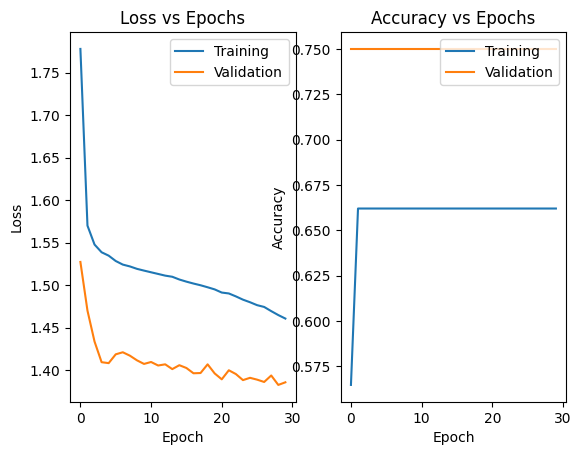

<Sequential name=sequential, built=True>

In [62]:
fit_nn(
    mlp_tuned,
    text_training=textvectors_training,
    labels_training=labels_perCategory_training,
    validationSplit=0.1
)

In [63]:
cnn_tuned = tune_nn(
    modelBuilder_cnn,
    text_training=textvectors_training,
    labels_training=labels_perCategory_training,
    validationSplit=0.1
    )

Reloading Tuner from .\untitled_project\tuner0.json


Epoch 1/30
7/7 - 2s - 269ms/step - accuracy: 0.6620 - loss: 0.6624 - val_accuracy: 0.7500 - val_loss: 0.6082
Epoch 2/30
7/7 - 0s - 12ms/step - accuracy: 0.6620 - loss: 0.6306 - val_accuracy: 0.7500 - val_loss: 0.5801
Epoch 3/30
7/7 - 0s - 10ms/step - accuracy: 0.6620 - loss: 0.6247 - val_accuracy: 0.7500 - val_loss: 0.5740
Epoch 4/30
7/7 - 0s - 11ms/step - accuracy: 0.6620 - loss: 0.6197 - val_accuracy: 0.7500 - val_loss: 0.5721
Epoch 5/30
7/7 - 0s - 11ms/step - accuracy: 0.6620 - loss: 0.6130 - val_accuracy: 0.7500 - val_loss: 0.5724
Epoch 6/30
7/7 - 0s - 11ms/step - accuracy: 0.6620 - loss: 0.6076 - val_accuracy: 0.7500 - val_loss: 0.5703
Epoch 7/30
7/7 - 0s - 11ms/step - accuracy: 0.6620 - loss: 0.6017 - val_accuracy: 0.7500 - val_loss: 0.5645
Epoch 8/30
7/7 - 0s - 9ms/step - accuracy: 0.6620 - loss: 0.5951 - val_accuracy: 0.7500 - val_loss: 0.5601
Epoch 9/30
7/7 - 0s - 10ms/step - accuracy: 0.6620 - loss: 0.5876 - val_accuracy: 0.7500 - val_loss: 0.5468
Epoch 10/30
7/7 - 0s - 12ms/

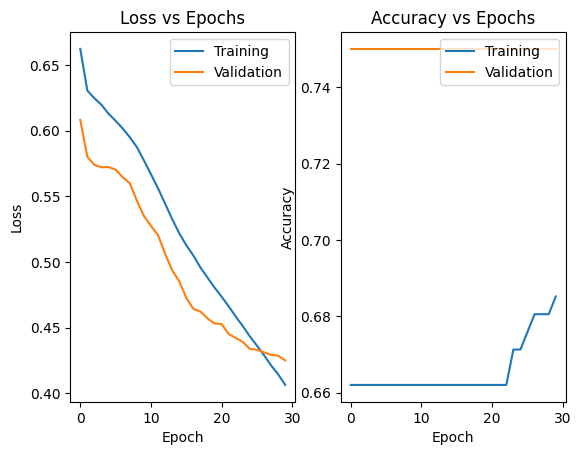

<Sequential name=sequential_1, built=True>

In [64]:
fit_nn(
    cnn_tuned,
    text_training=textvectors_training,
    labels_training=labels_perCategory_training,
    validationSplit=0.1
)

In [65]:
lstm_tuned = tune_nn(
    modelBuilder_lstm,
    text_training=textvectors_training,
    labels_training=labels_perCategory_training,
    validationSplit=0.1
    )

Reloading Tuner from .\untitled_project\tuner0.json


Epoch 1/30
7/7 - 6s - 862ms/step - accuracy: 0.1944 - loss: 3.5025 - val_accuracy: 0.2083 - val_loss: 1.1095
Epoch 2/30
7/7 - 0s - 55ms/step - accuracy: 0.2593 - loss: 1.0187 - val_accuracy: 0.2917 - val_loss: 0.7381
Epoch 3/30
7/7 - 0s - 53ms/step - accuracy: 0.5417 - loss: 0.8478 - val_accuracy: 0.7500 - val_loss: 0.6363
Epoch 4/30
7/7 - 0s - 52ms/step - accuracy: 0.6065 - loss: 0.7378 - val_accuracy: 0.7500 - val_loss: 0.5739
Epoch 5/30
7/7 - 0s - 49ms/step - accuracy: 0.5972 - loss: 0.7200 - val_accuracy: 0.7500 - val_loss: 0.5293
Epoch 6/30
7/7 - 0s - 52ms/step - accuracy: 0.6157 - loss: 0.6866 - val_accuracy: 0.7500 - val_loss: 0.5001
Epoch 7/30
7/7 - 0s - 49ms/step - accuracy: 0.6343 - loss: 0.5777 - val_accuracy: 0.7500 - val_loss: 0.4838
Epoch 8/30
7/7 - 0s - 49ms/step - accuracy: 0.6620 - loss: 0.6177 - val_accuracy: 0.7500 - val_loss: 0.4698
Epoch 9/30
7/7 - 0s - 58ms/step - accuracy: 0.6528 - loss: 0.6463 - val_accuracy: 0.7500 - val_loss: 0.4614
Epoch 10/30
7/7 - 0s - 49ms

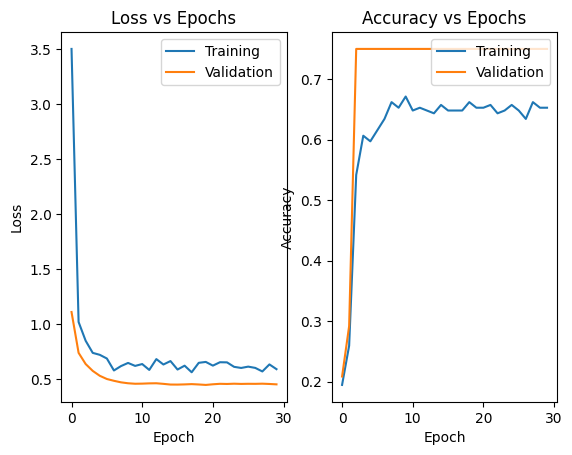

<Sequential name=sequential_2, built=True>

In [66]:
fit_nn(
    lstm_tuned,
    text_training=textvectors_training,
    labels_training=labels_perCategory_training,
    validationSplit=0.1
)

### Evaluating model performance

In [67]:
predictions['svm'], measurements_svm = evaluate_model(
    model=svm_tuned,
    text_testing=textvectors_testing,
    labels_testing=predictions['real'],
    model_outputIsMultidimensional=False
    )

c:\Users\efren\Documents\GitHub\Projects\venvNLP_AlgorithmComparison\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\efren\Documents\GitHub\Projects\venvNLP_AlgorithmComparison\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\efren\Documents\GitHub\Projects\venvNLP_AlgorithmComparison\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

In [68]:
predictions['dt'], measurements_dt = evaluate_model(
    model=dt_tuned,
    text_testing=textvectors_testing,
    labels_testing=predictions['real'],
    model_outputIsMultidimensional=False
    )

In [69]:
predictions['lr'], measurements_lr = evaluate_model(
    model=lr_tuned,
    text_testing=textvectors_testing,
    labels_testing=predictions['real'],
    model_outputIsMultidimensional=False
    )

In [70]:
predictions['rf'], measurements_rf = evaluate_model(
    model=rf_tuned,
    text_testing=textvectors_testing,
    labels_testing=predictions['real'],
    model_outputIsMultidimensional=False
    )

c:\Users\efren\Documents\GitHub\Projects\venvNLP_AlgorithmComparison\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\efren\Documents\GitHub\Projects\venvNLP_AlgorithmComparison\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\efren\Documents\GitHub\Projects\venvNLP_AlgorithmComparison\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

In [71]:
predictions['mlp'], measurements_mlp = evaluate_model(
    model=mlp_tuned,
    text_testing=textvectors_testing,
    labels_testing=predictions['real'],
    model_outputIsMultidimensional=True
    )

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


c:\Users\efren\Documents\GitHub\Projects\venvNLP_AlgorithmComparison\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\efren\Documents\GitHub\Projects\venvNLP_AlgorithmComparison\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\efren\Documents\GitHub\Projects\venvNLP_AlgorithmComparison\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

In [72]:
predictions['cnn'], measurements_cnn = evaluate_model(
    model=cnn_tuned,
    text_testing=textvectors_testing,
    labels_testing=predictions['real'],
    model_outputIsMultidimensional=True
    )

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


c:\Users\efren\Documents\GitHub\Projects\venvNLP_AlgorithmComparison\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\efren\Documents\GitHub\Projects\venvNLP_AlgorithmComparison\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\efren\Documents\GitHub\Projects\venvNLP_AlgorithmComparison\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

In [73]:
predictions['lstm'], measurements_lstm = evaluate_model(
    model=lstm_tuned,
    text_testing=textvectors_testing,
    labels_testing=predictions['real'],
    model_outputIsMultidimensional=True
    )

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000026BB7017600> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 357ms/step


c:\Users\efren\Documents\GitHub\Projects\venvNLP_AlgorithmComparison\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\efren\Documents\GitHub\Projects\venvNLP_AlgorithmComparison\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\efren\Documents\GitHub\Projects\venvNLP_AlgorithmComparison\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

In [74]:
measurements = pd.concat(
    [
        measurements_svm,
        measurements_dt,
        measurements_lr,
        measurements_rf,
        measurements_mlp,
        measurements_cnn,
        measurements_lstm
        ],
    keys={
        'svm',
        'dt',
        'lr',
        'rf',
        'mlp',
        'cnn',
        'lstm'
        }
    )
print(predictions)
print(measurements)

          real       svm         dt         lr        rf       mlp       cnn  \
216  ambiguous  positive  ambiguous  ambiguous  positive  positive  positive   
196   negative  positive   negative   negative  positive  positive  positive   
12    positive  positive   positive   positive  positive  positive  positive   
229   negative  positive   negative   positive  positive  positive  positive   
247   negative  positive   negative   negative  positive  positive  positive   
144   positive  positive   positive   positive  positive  positive  positive   
238   negative  positive  ambiguous   positive  positive  positive  positive   
214   positive  positive   positive   positive  positive  positive  positive   
52    positive  positive   positive   positive  positive  positive  positive   
108   positive  positive   positive   positive  positive  positive  positive   
300   positive  positive   positive   positive  positive  positive  positive   
15    negative  positive  ambiguous   po

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c08bdf8c-7c67-4c50-96b4-a5db5ca2fd09' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>